# Q1 Analysis 
Creates a gold table at `data/gold/zillow/q1/q1_analysis.parquet` with columns:
`[Date, Region, RegionType, MedianSalePrice, MedianListingPrice, SaleToListRatio, PctSoldAboveList, PctSoldBelowList, DaysOnMarket]`.

In [268]:
from pathlib import Path
import polars as pl

def log(msg: str) -> None:
    print(f'[Q1] {msg}')

def find_repo_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    for p in (start, *start.parents):
        if (p / 'ETL').is_dir() and (p / 'scripts').is_dir():
            return p
    return start  # fallback

ROOT = find_repo_root()
SILVER = ROOT / 'data' / 'silver' / 'zillow'
GOLD = ROOT / 'data' / 'gold' / 'zillow' / 'q1'  # Fixed: Added q1 subdirectory

sales_path = SILVER / 'sales' / 'wide.parquet'
listings_path = SILVER / 'for_sale_listings' / 'wide.parquet'
dom_path = SILVER / 'days_on_market' / 'wide.parquet'

for p in (sales_path, listings_path, dom_path):
    if not p.exists():
        raise FileNotFoundError(f'Missing required silver file: {p}')

log('Input silver files located.')

[Q1] Input silver files located.


In [269]:
# Inspect schemas and confirm required columns exist
sales_cols = list(pl.read_parquet(str(sales_path), n_rows=0).schema.keys())
listings_cols = list(pl.read_parquet(str(listings_path), n_rows=0).schema.keys())
dom_cols = list(pl.read_parquet(str(dom_path), n_rows=0).schema.keys())

print('sales columns:', sales_cols)
print('listings columns:', listings_cols)
print('dom columns:', dom_cols)

needed_sales = ['State', 'date', 'Median Sale Price', 'Median Sale to List Ratio', '% Sold Above List', '% Sold Below List']
needed_listings = ['State', 'date', 'Median Listing Price']
needed_dom = ['State', 'date', 'Median Days on Pending']

missing = {
    'sales': [c for c in needed_sales if c not in sales_cols],
    'listings': [c for c in needed_listings if c not in listings_cols],
    'days_on_market': [c for c in needed_dom if c not in dom_cols],
}
missing


sales columns: ['Region ID', 'Size Rank', 'Region', 'Region Type', 'State', 'Home Type', 'Date', 'Mean Sale to List Ratio (Smoothed)', 'Median Sale to List Ratio', 'Median Sale Price', 'Median Sale Price (Smoothed) (Seasonally Adjusted)', 'Median Sale Price (Smoothed)', 'Median Sale to List Ratio (Smoothed)', '% Sold Below List', '% Sold Below List (Smoothed)', '% Sold Above List', '% Sold Above List (Smoothed)', 'Mean Sale to List Ratio', 'date', 'Region Type Name', 'Home Type Name', 'year', 'month', 'quarter']
listings columns: ['Region ID', 'Size Rank', 'Region', 'Region Type', 'State', 'Home Type', 'Date', 'Median Listing Price', 'Median Listing Price (Smoothed)', 'New Listings', 'New Listings (Smoothed)', 'New Pending (Smoothed)', 'New Pending', 'date', 'Region Type Name', 'Home Type Name', 'year', 'month', 'quarter']
dom columns: ['Region ID', 'Size Rank', 'Region', 'Region Type', 'State', 'Home Type', 'Date', 'Mean Listings Price Cut Amount (Smoothed)', 'Percent Listings Price C

{'sales': [], 'listings': [], 'days_on_market': []}

In [270]:
# # Build per-dataset state-level tables and write debug outputs
# DEBUG_DIR = GOLD / 'debug'
# DEBUG_DIR.mkdir(parents=True, exist_ok=True)

# # Normalize date to Date for key consistency
# to_date = pl.col('date').cast(pl.Date).alias('Date')

# df_sales_state = (
#     pl.scan_parquet(str(sales_path))
#     .select(
#         'State',
#         'date',
#         pl.col('Median Sale Price').alias('MedianSalePrice'),
#         pl.col('Median Sale to List Ratio').alias('SaleToListRatio'),
#         pl.col('% Sold Above List').alias('PctSoldAboveList'),
#         pl.col('% Sold Below List').alias('PctSoldBelowList'),
#     )
#     .with_columns(to_date)
#     .group_by(['State', 'Date'])
#     .agg([
#         pl.col('MedianSalePrice').median().alias('MedianSalePrice'),
#         pl.col('SaleToListRatio').median().alias('SaleToListRatio'),
#         pl.col('PctSoldAboveList').mean().alias('PctSoldAboveList'),
#         pl.col('PctSoldBelowList').mean().alias('PctSoldBelowList'),
#     ])
# ).collect()
# df_sales_state.write_parquet(str(DEBUG_DIR / 'sales_state.parquet'))
# df_sales_state.shape, df_sales_state.head()

In [271]:
# df_listings_state = (
#     pl.scan_parquet(str(listings_path))
#     .select(
#         'State',
#         'date',
#         pl.col('Median Listing Price').alias('MedianListingPrice'),
#     )
#     .with_columns(to_date)
#     .group_by(['State', 'Date'])
#     .agg(pl.col('MedianListingPrice').median().alias('MedianListingPrice'))
# ).collect()
# df_listings_state.write_parquet(str(DEBUG_DIR / 'listings_state.parquet'))
# df_listings_state.shape, df_listings_state.head()

In [272]:
# df_dom_state = (
#     pl.scan_parquet(str(dom_path))
#     .select(
#         'State',
#         'date',
#         pl.col('Median Days on Pending').alias('DaysOnMarket'),
#     )
#     .with_columns(to_date)
#     .group_by(['State', 'Date'])
#     .agg(pl.col('DaysOnMarket').median().alias('DaysOnMarket'))
# ).collect()
# df_dom_state.write_parquet(str(DEBUG_DIR / 'dom_state.parquet'))
# df_dom_state.shape, df_dom_state.head()

In [273]:
# # Merge the debug tables (inner join on State+Date)
# lf = (
#     df_sales_state.lazy()
#     .join(df_listings_state.lazy(), on=['State', 'Date'], how='inner')
#     .join(df_dom_state.lazy(), on=['State', 'Date'], how='inner')
#     .with_columns([
#         pl.col('State').alias('Region'),
#         pl.lit('State').alias('RegionType'),
#     ])
#     .select([
#         'Date',
#         'Region',
#         'RegionType',
#         'MedianSalePrice',
#         'MedianListingPrice',
#         'SaleToListRatio',
#         'PctSoldAboveList',
#         'PctSoldBelowList',
#         'DaysOnMarket',
#     ])
#     .sort(['Date', 'Region'])
# )
# df = lf.collect()
# df.shape, df.head()

In [274]:
# # Write to gold layer
# GOLD.mkdir(parents=True, exist_ok=True)
# out_path = GOLD / 'q1_analysis.parquet'
# df.write_parquet(str(out_path))
# log(f'Wrote {out_path} with {df.height} rows and {len(df.columns)} columns.')
# out_path.as_posix(), df.shape

In [275]:
# metrics_lf = (
#     df.lazy()
#     .with_columns(
#         (
#             (pl.col('MedianSalePrice') - pl.col('MedianListingPrice')) 
#             / pl.col('MedianListingPrice') * 100
#         ).alias('SaleListGapPct')
#     )
#     .group_by('Region')
#     .agg([
#         pl.col('SaleListGapPct').std().alias('Volatility_SaleListGapPct'),
#         pl.col('SaleListGapPct').mean().alias('Avg_SaleListGapPct'),
#         pl.col('PctSoldAboveList').mean().alias('Avg_PctSoldAboveList'),
#         pl.col('DaysOnMarket').mean().alias('Avg_DaysOnMarket'),
#         pl.len().alias('Observations'),
#     ])
#     .with_columns(
#         pl.lit('State').alias('RegionType')
#     )
#     .select([
#         'Region',
#         'RegionType',
#         'Avg_SaleListGapPct',
#         'Volatility_SaleListGapPct',
#         'Avg_PctSoldAboveList',
#         'Avg_DaysOnMarket',
#         'Observations'
#     ])
#     .sort('Region')
# )

# metrics_df = metrics_lf.collect()

# # Write metrics to gold
# metrics_path = GOLD / 'demand_consistency.parquet'
# metrics_df.write_parquet(str(metrics_path))

# log(f'Wrote {metrics_path} with {metrics_df.height} rows and {len(metrics_df.columns)} columns.')

# metrics_df.shape, metrics_df.head()

In [276]:
# Above parts are a bit weird which calculate some really strange data. As so we conduct the following to verify weekly aggregation.

import polars as pl
from pathlib import Path

START = pl.date(2018, 1, 6)

# Assume these exist:
# sales_path, listings_path, dom_path, GOLD
DEBUG_DIR = Path(GOLD) / "debug_q1_weekly"
DEBUG_DIR.mkdir(parents=True, exist_ok=True)

to_date = pl.col("date").cast(pl.Date).alias("Date")

# SALES (one row per State×Week) - CORRECTED LOGIC
sales_w = (
    pl.scan_parquet(str(sales_path))
    .select(
        pl.col("State"),
        pl.col("date"),
        pl.col("Median Sale Price").alias("MedianSalePrice"),
        pl.col("Median Sale to List Ratio").alias("SaleToListRatio"),
        
        # CORRECTED: Normalize PctAbove/PctBelow to be on a [0, 100] scale before aggregation
        pl.when(pl.col("% Sold Above List") <= 1.5)
          .then(pl.col("% Sold Above List") * 100)
          .otherwise(pl.col("% Sold Above List"))
          .alias("PctAbove_norm"),
        pl.when(pl.col("% Sold Below List") <= 1.5)
          .then(pl.col("% Sold Below List") * 100)
          .otherwise(pl.col("% Sold Below List"))
          .alias("PctBelow_norm"),
    )
    .with_columns(to_date)
    .filter(pl.col("Date") >= START)
    .group_by(["State", "Date"]) 
    .agg([
        pl.col("MedianSalePrice").median().alias("MedianSalePrice_w"),
        pl.col("SaleToListRatio").median().alias("SaleToListRatio_w"),
        # Now, simply take the mean of the normalized columns
        pl.col("PctAbove_norm").mean().alias("PctSoldAboveList_w"),
        pl.col("PctBelow_norm").mean().alias("PctSoldBelowList_w"),
    ])
    .collect()
)
sales_w.write_parquet(str(DEBUG_DIR / "sales_state_weekly.parquet"))
print("sales_w:", sales_w.shape, sales_w.columns[:10])
print(sales_w.head())

sales_w: (13020, 6) ['State', 'Date', 'MedianSalePrice_w', 'SaleToListRatio_w', 'PctSoldAboveList_w', 'PctSoldBelowList_w']
shape: (5, 6)
┌───────┬────────────┬───────────────────┬───────────────────┬──────────────────┬──────────────────┐
│ State ┆ Date       ┆ MedianSalePrice_w ┆ SaleToListRatio_w ┆ PctSoldAboveList ┆ PctSoldBelowList │
│ ---   ┆ ---        ┆ ---               ┆ ---               ┆ _w               ┆ _w               │
│ str   ┆ date       ┆ f32               ┆ f32               ┆ ---              ┆ ---              │
│       ┆            ┆                   ┆                   ┆ f32              ┆ f32              │
╞═══════╪════════════╪═══════════════════╪═══════════════════╪══════════════════╪══════════════════╡
│ SC    ┆ 2020-08-15 ┆ 235007.0          ┆ 0.984263          ┆ 15.941327        ┆ 65.67643         │
│ ID    ┆ 2021-02-27 ┆ 400750.0          ┆ null              ┆ null             ┆ null             │
│ WA    ┆ 2019-06-15 ┆ 363560.0          ┆ 1.0        

In [277]:
# import polars as pl
# from datetime import date

# # --- paths ---
# raw = pl.scan_parquet(str(sales_path))      # lazy scan for raw data
# sales_w = pl.read_parquet(str(DEBUG_DIR / "sales_state_weekly.parquet"))

# # --- helper ---
# def check(state: str, date_str: str):
#     # convert to Python date
#     d = pl.lit(date.fromisoformat(date_str))  

#     df = (
#         raw
#         .filter(
#             (pl.col("State") == state)
#             & (pl.col("date").cast(pl.Date) == d)
#         )
#         .select(
#             "State",
#             pl.col("date").cast(pl.Date).alias("Date"),
#             pl.col("Median Sale Price").alias("MedianSalePrice"),
#             pl.col("Median Sale to List Ratio").alias("SaleToListRatio"),
#             pl.when(pl.col("% Sold Above List") <= 1.5)
#               .then(pl.col("% Sold Above List") * 100)
#               .otherwise(pl.col("% Sold Above List"))
#               .alias("PctAbove_norm"),
#             pl.when(pl.col("% Sold Below List") <= 1.5)
#               .then(pl.col("% Sold Below List") * 100)
#               .otherwise(pl.col("% Sold Below List"))
#               .alias("PctBelow_norm"),
#         )
#         .collect()
#     )

#     print(f"\nRaw rows for ({state}, {date_str}):")
#     print(df)

#     if df.is_empty():
#         print("⚠️  No matching raw rows found.")
#         return

#     agg = df.select([
#         pl.col("MedianSalePrice").median().alias("MedianSalePrice_w"),
#         pl.col("SaleToListRatio").median().alias("SaleToListRatio_w"),
#         pl.col("PctAbove_norm").mean().alias("PctSoldAboveList_w"),
#         pl.col("PctBelow_norm").mean().alias("PctSoldBelowList_w"),
#     ])
#     print(f"\nRecomputed weekly values for ({state}, {date_str}):")
#     print(agg)

#     target = sales_w.filter(
#         (pl.col("State") == state)
#         & (pl.col("Date") == date.fromisoformat(date_str))
#     )
#     print(f"\nRow in sales_w for ({state}, {date_str}):")
#     print(target)

# # --- examples from screenshot ---
# check("PA", "2023-05-06")
# check("TX", "2019-02-16")
# check("AL", "2021-11-20")
# check("MN", "2018-08-04")
# check("CA", "2023-01-28")


In [278]:
# LISTINGS (one row per State×Week)
listings_w = (
    pl.scan_parquet(str(listings_path))
    .select(
        pl.col("State"),
        pl.col("date"),
        pl.col("Median Listing Price").alias("MedianListingPrice"),
    )
    .with_columns(to_date)
    .filter(pl.col("Date") >= START)
    .group_by(["State", "Date"])
    .agg(pl.col("MedianListingPrice").median().alias("MedianListingPrice_w"))
    .collect()
)
listings_w.write_parquet(str(DEBUG_DIR / "listings_state_weekly.parquet"))
print("listings_w:", listings_w.shape, listings_w.columns[:10])
print(listings_w.head())

listings_w: (16012, 3) ['State', 'Date', 'MedianListingPrice_w']
shape: (5, 3)
┌───────┬────────────┬──────────────────────┐
│ State ┆ Date       ┆ MedianListingPrice_w │
│ ---   ┆ ---        ┆ ---                  │
│ str   ┆ date       ┆ f32                  │
╞═══════╪════════════╪══════════════════════╡
│ HI    ┆ 2021-02-20 ┆ 823250.0             │
│ UT    ┆ 2018-09-15 ┆ 342400.0             │
│ SC    ┆ 2020-11-07 ┆ 239450.0             │
│ AR    ┆ 2018-01-27 ┆ 139300.0             │
│ NJ    ┆ 2020-12-05 ┆ 304950.0             │
└───────┴────────────┴──────────────────────┘


In [279]:
# SPEED (Days to Pending) — this is not full DOM, but good speed proxy
speed_w = (
    pl.scan_parquet(str(dom_path))
    .select(
        pl.col("State"),
        pl.col("date"),
        pl.col("Median Days on Pending").alias("DaysToPending"),
    )
    .with_columns(to_date)
    .filter(pl.col("Date") >= START)
    .group_by(["State", "Date"])
    .agg(pl.col("DaysToPending").median().alias("DaysToPending_w"))
    .collect()
)
speed_w.write_parquet(str(DEBUG_DIR / "days_to_pending_state_weekly.parquet"))
print("speed_w:", speed_w.shape, speed_w.columns[:10])
print(speed_w.head())

speed_w: (16217, 3) ['State', 'Date', 'DaysToPending_w']
shape: (5, 3)
┌───────┬────────────┬─────────────────┐
│ State ┆ Date       ┆ DaysToPending_w │
│ ---   ┆ ---        ┆ ---             │
│ str   ┆ date       ┆ f32             │
╞═══════╪════════════╪═════════════════╡
│ TX    ┆ 2021-12-11 ┆ 12.0            │
│ WA    ┆ 2024-01-20 ┆ 26.0            │
│ WA    ┆ 2021-01-02 ┆ 7.0             │
│ AR    ┆ 2020-11-28 ┆ null            │
│ LA    ┆ 2019-04-20 ┆ 31.0            │
└───────┴────────────┴─────────────────┘


In [280]:
weekly = (
    sales_w.lazy()
    .join(listings_w.lazy(), on=["State", "Date"], how="inner")
    .join(speed_w.lazy(), on=["State", "Date"], how="inner")
    .with_columns([
        # 1) Calculate intermediate components
        ((pl.col("SaleToListRatio_w") - 1.0) * 100.0).alias("Gap_from_ratio"),
        pl.when(
            pl.col("MedianListingPrice_w").is_not_null() & (pl.col("MedianListingPrice_w") > 0) &
            pl.col("MedianSalePrice_w").is_not_null()
        )
        .then((pl.col("MedianSalePrice_w") - pl.col("MedianListingPrice_w"))
              / pl.col("MedianListingPrice_w") * 100.0)
        .otherwise(None)
        .alias("Gap_from_prices"),
    ])
    .with_columns([
        # 2) Calculate final gap using the new columns and then apply clips
        pl.coalesce([pl.col("Gap_from_ratio"), pl.col("Gap_from_prices")]).alias("SaleListGapPct_w"),
    ])
    .with_columns([
        # 3) Apply clips (needs to happen after SaleListGapPct_w is created)
        # Note: Polars allows reusing the alias name here to overwrite the column
        pl.col("SaleListGapPct_w").clip(-20.0, 20.0).alias("SaleListGapPct_w"),
        pl.col("DaysToPending_w").clip(3.0, 150.0).alias("DaysToPending_w"),
        pl.col("PctSoldAboveList_w").clip(0.0, 100.0).alias("PctSoldAboveList_w"),
    ])
    .select([
        "State", "Date",
        "MedianSalePrice_w", "MedianListingPrice_w", "SaleToListRatio_w",
        "PctSoldAboveList_w", "PctSoldBelowList_w",
        "DaysToPending_w", "SaleListGapPct_w",
    ])
    .collect()
)

weekly.write_parquet(str(DEBUG_DIR / "state_weekly_joined.parquet"))
print("weekly:", weekly.shape, weekly.columns)

weekly: (12710, 9) ['State', 'Date', 'MedianSalePrice_w', 'MedianListingPrice_w', 'SaleToListRatio_w', 'PctSoldAboveList_w', 'PctSoldBelowList_w', 'DaysToPending_w', 'SaleListGapPct_w']


In [281]:
# Use a 4-week rolling mean (within each state) ONLY for volatility
weekly_sm = (
    weekly.lazy()
    .with_columns(
        pl.col("SaleListGapPct_w")
        .rolling_mean(window_size=4, min_samples=1)  # renamed argument
        .over("State")
        .alias("SaleListGapPct_w_smoothed")
    )
    .collect()
)

print("weekly_sm:", weekly_sm.shape, weekly_sm.columns)
print(weekly_sm.head())

weekly_sm: (12710, 10) ['State', 'Date', 'MedianSalePrice_w', 'MedianListingPrice_w', 'SaleToListRatio_w', 'PctSoldAboveList_w', 'PctSoldBelowList_w', 'DaysToPending_w', 'SaleListGapPct_w', 'SaleListGapPct_w_smoothed']
shape: (5, 10)
┌───────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ State ┆ Date       ┆ MedianSale ┆ MedianList ┆ … ┆ PctSoldBe ┆ DaysToPen ┆ SaleListG ┆ SaleListG │
│ ---   ┆ ---        ┆ Price_w    ┆ ingPrice_w ┆   ┆ lowList_w ┆ ding_w    ┆ apPct_w   ┆ apPct_w_s │
│ str   ┆ date       ┆ ---        ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ moothed   │
│       ┆            ┆ f32        ┆ f32        ┆   ┆ f32       ┆ f32       ┆ f32       ┆ ---       │
│       ┆            ┆            ┆            ┆   ┆           ┆           ┆           ┆ f32       │
╞═══════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ TX    ┆ 2021-12-11 ┆ 271030.0   ┆ 249450.0   ┆ … ┆ 37.399

In [282]:
# Guard: ensure % above-list is in 0–100 (not 0–1)
# weekly_sm = weekly_sm.with_columns(
#     pl.when(pl.col("PctSoldAboveList_w") <= 1.5)
#       .then(pl.col("PctSoldAboveList_w") * 100)
#       .otherwise(pl.col("PctSoldAboveList_w"))
#       .alias("PctSoldAboveList_w")
# )

# Summarize 2018-01-06 → latest by state
metrics = (
    weekly_sm.lazy()
    .group_by("State")
    .agg([
        pl.col("SaleListGapPct_w").mean().alias("Avg_SaleListGapPct"),
        pl.col("SaleListGapPct_w_smoothed").std().alias("Volatility_SaleListGapPct"),
        pl.col("PctSoldAboveList_w").mean().alias("Avg_PctSoldAboveList"),
        pl.col("DaysToPending_w").mean().alias("Avg_DaysToPending"),
        pl.len().alias("Observations"),
    ])
    .filter(pl.col("Observations") >= 260)  # ~5 years of weeks
    .with_columns([
        pl.col("State").alias("Region"),
        pl.lit("State").alias("RegionType"),
    ])
    .select([
        "Region","RegionType",
        "Avg_SaleListGapPct","Volatility_SaleListGapPct",
        "Avg_PctSoldAboveList","Avg_DaysToPending","Observations",
    ])
    .collect()
)
print("metrics rows:", metrics.shape[0])
print(metrics.head())


metrics rows: 41
shape: (5, 7)
┌────────┬────────────┬───────────────┬───────────────┬──────────────┬──────────────┬──────────────┐
│ Region ┆ RegionType ┆ Avg_SaleListG ┆ Volatility_Sa ┆ Avg_PctSoldA ┆ Avg_DaysToPe ┆ Observations │
│ ---    ┆ ---        ┆ apPct         ┆ leListGapPct  ┆ boveList     ┆ nding        ┆ ---          │
│ str    ┆ str        ┆ ---           ┆ ---           ┆ ---          ┆ ---          ┆ u32          │
│        ┆            ┆ f32           ┆ f32           ┆ f32          ┆ f32          ┆              │
╞════════╪════════════╪═══════════════╪═══════════════╪══════════════╪══════════════╪══════════════╡
│ CA     ┆ State      ┆ 0.244769      ┆ 0.482674      ┆ 44.960342    ┆ 16.098387    ┆ 310          │
│ MA     ┆ State      ┆ 0.440923      ┆ 0.807331      ┆ 44.391872    ┆ 12.890323    ┆ 310          │
│ OH     ┆ State      ┆ -0.637258     ┆ 0.623357      ┆ 34.950687    ┆ 16.485483    ┆ 310          │
│ WI     ┆ State      ┆ 8.627356      ┆ 3.534332      ┆ 56.1

In [283]:
import polars as pl

# --- helper for z-score computation ---
def zcol(df: pl.DataFrame, col: str, out: str, invert: bool = False) -> pl.DataFrame:
    s = df[col]
    mu = float(s.mean())
    sd = float(s.std() or 1.0)
    z = (s - mu) / sd
    if invert:
        z = -z
    return df.with_columns(pl.Series(out, z))

# --- base dataframe ---
rank_df = metrics.clone()

# --- compute z-scores ---
rank_df = zcol(rank_df, "Avg_SaleListGapPct",        "z_gap")                     # demand pressure
rank_df = zcol(rank_df, "Volatility_SaleListGapPct", "z_stability", invert=True)  # lower volatility = better
rank_df = zcol(rank_df, "Avg_PctSoldAboveList",      "z_above")                   # competitive intensity
rank_df = zcol(rank_df, "Avg_DaysToPending",         "z_speed", invert=True)      # market speed

# --- set weights (must sum to 1 for normalized score) ---
w_gap       = 0.25   # importance of sale-to-list gap
w_stability = 0.30   # importance of stability (volatility inverse)
w_above     = 0.20   # importance of % above list
w_speed     = 0.25   # importance of transaction speed

# --- compute weighted composite index ---
rank_df = rank_df.with_columns(
    (
        w_gap * pl.col("z_gap") +
        w_stability * pl.col("z_stability") +
        w_above * pl.col("z_above") +
        w_speed * pl.col("z_speed")
    ).alias("DemandConsistencyIndex")
).sort("DemandConsistencyIndex", descending=True)

# --- display top results ---
print("Top 10 states by consistent demand (weighted):")
print(rank_df.select(["Region", "DemandConsistencyIndex"]).head(10))

# --- save ---
rank_path = GOLD / "demand_consistency_ranked_weekly.parquet"
metrics_path = GOLD / "demand_consistency_metrics_weekly.parquet"
metrics.write_parquet(str(metrics_path))
rank_df.write_parquet(str(rank_path))


Top 10 states by consistent demand (weighted):
shape: (10, 2)
┌────────┬────────────────────────┐
│ Region ┆ DemandConsistencyIndex │
│ ---    ┆ ---                    │
│ str    ┆ f32                    │
╞════════╪════════════════════════╡
│ AR     ┆ null                   │
│ NH     ┆ null                   │
│ WA     ┆ 0.690724               │
│ MA     ┆ 0.55945                │
│ CO     ┆ 0.534217               │
│ NC     ┆ 0.525213               │
│ VA     ┆ 0.520768               │
│ OR     ┆ 0.517594               │
│ CA     ┆ 0.484468               │
│ MO     ┆ 0.411288               │
└────────┴────────────────────────┘


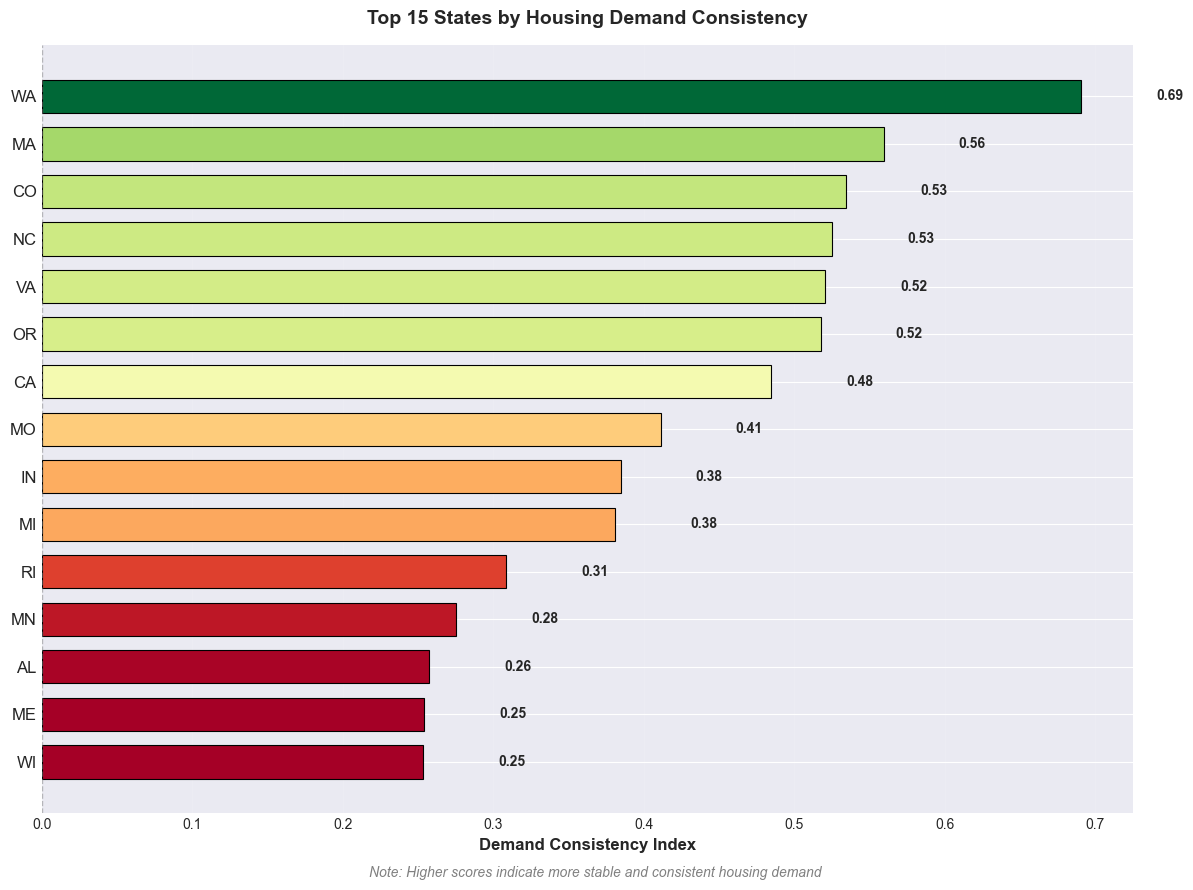


Rank   State     Index  Data Quality
-----------------------------------
1      WA        0.691  (4/4 metrics)
2      MA        0.559  (4/4 metrics)
3      CO        0.534  (4/4 metrics)
4      NC        0.525  (4/4 metrics)
5      VA        0.521  (4/4 metrics)
6      OR        0.518  (4/4 metrics)
7      CA        0.484  (4/4 metrics)
8      MO        0.411  (4/4 metrics)
9      IN        0.385  (4/4 metrics)
10     MI        0.381  (4/4 metrics)
11     RI        0.308  (4/4 metrics)
12     MN        0.275  (4/4 metrics)
13     AL        0.257  (4/4 metrics)
14     ME        0.254  (4/4 metrics)
15     WI        0.253  (4/4 metrics)

✓ Saved: D:\code\SEG\data\gold\zillow\q1\demand_consistency_chart.png


<Figure size 640x480 with 0 Axes>

In [284]:
# === CLEAN BAR CHART: NO OVERLAPS ===

import matplotlib.pyplot as plt
import numpy as np

# Get top 15 states (20 is too crowded)
top_states = rank_df.filter(pl.col("DemandConsistencyIndex").is_not_null()).head(15)

# Extract data
states = top_states['Region'].to_list()
indices = top_states['DemandConsistencyIndex'].to_list()
metrics_avail = top_states['_available_metrics'].to_list() if '_available_metrics' in top_states.columns else [4] * len(states)

# Create figure with more height
fig, ax = plt.subplots(figsize=(12, 9))

# Create color mapping
norm = plt.Normalize(vmin=min(indices), vmax=max(indices))
colors = plt.cm.RdYlGn(norm(indices))

# Create horizontal bars with more spacing
y_pos = np.arange(len(states))
bars = ax.barh(y_pos, indices, height=0.7, color=colors, edgecolor='black', linewidth=0.8)

# Customize axes
ax.set_yticks(y_pos)
ax.set_yticklabels(states, fontsize=12)
ax.set_xlabel('Demand Consistency Index', fontsize=12, fontweight='bold')
ax.set_title('Top 15 States by Housing Demand Consistency', 
             fontsize=14, fontweight='bold', pad=15)

# Add value labels ONLY - no overlapping badges
for i, (bar, value) in enumerate(zip(bars, indices)):
    width = bar.get_width()
    # Place label outside the bar
    ax.text(width + 0.05, bar.get_y() + bar.get_height()/2, 
            f'{value:.2f}',
            ha='left', va='center', fontsize=10, fontweight='bold')

# Invert y-axis
ax.invert_yaxis()

# Add zero line
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Grid
ax.grid(axis='x', alpha=0.2, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Clean spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add simple note at bottom
note = 'Note: Higher scores indicate more stable and consistent housing demand'
fig.text(0.5, 0.02, note, ha='center', fontsize=10, style='italic', color='gray')

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

# Print clean table
print(f"\n{'Rank':<6} {'State':<6} {'Index':>8}  {'Data Quality'}")
print("-" * 35)
for i, row in enumerate(top_states.iter_rows(named=True)):
    metrics = row.get('_available_metrics', 4)
    print(f"{i+1:<6} {row['Region']:<6} {row['DemandConsistencyIndex']:>8.3f}  ({metrics}/4 metrics)")

# Save
fig_path = GOLD / 'demand_consistency_chart.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✓ Saved: {fig_path}")

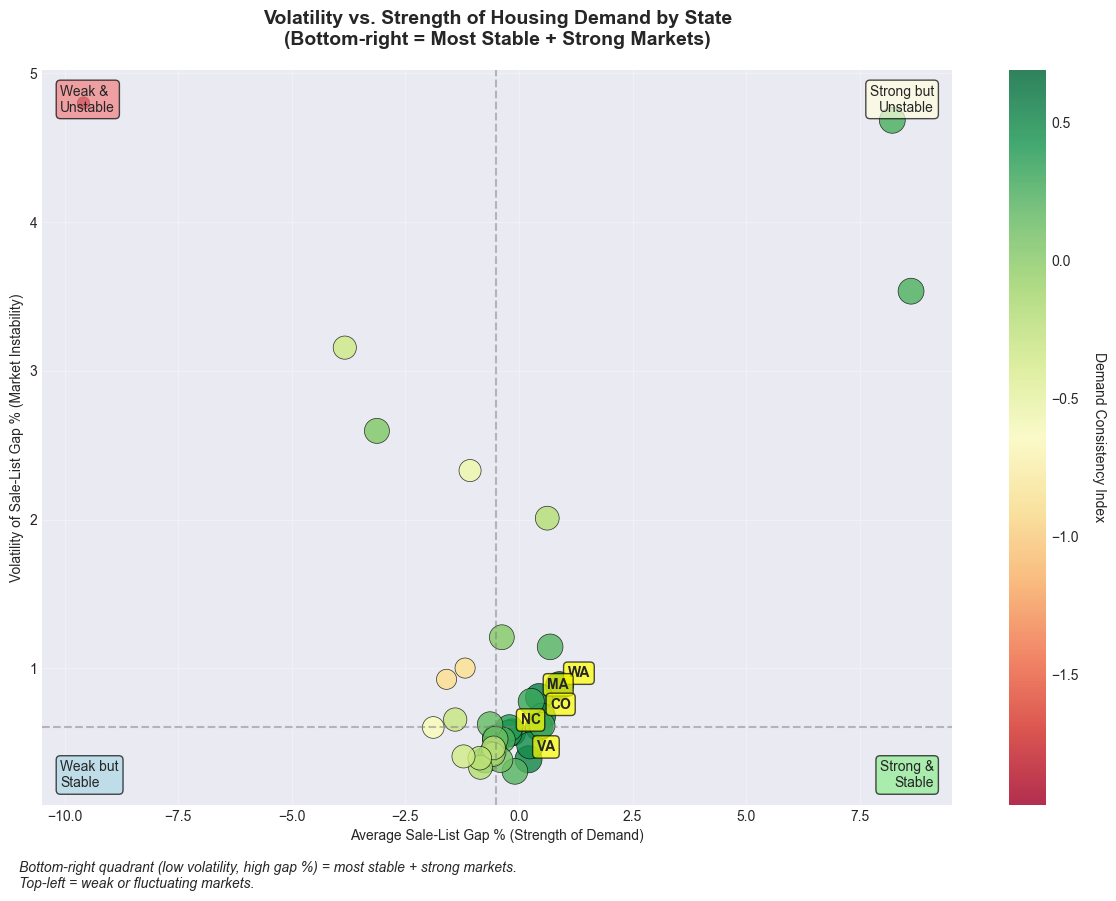

<Figure size 640x480 with 0 Axes>

Market Quadrant Analysis:
Strong & Stable: 8 states -> ['NC', 'VA', 'CA', 'MO', 'MI', 'NM', 'MD', 'GA']
Weak & Unstable: 8 states -> ['OH', 'NE', 'IL', 'UT', 'NJ', 'LA', 'DE', 'HI']


In [285]:
import numpy as np
import matplotlib.pyplot as plt

# keep only rows with needed fields
scatter_data = rank_df.filter(
    pl.all_horizontal(
        pl.col("DemandConsistencyIndex").is_not_null(),
        pl.col("Avg_SaleListGapPct").is_not_null(),
        pl.col("Volatility_SaleListGapPct").is_not_null()
    )
)

# Extract columns (as Python lists / numpy)
x = scatter_data["Avg_SaleListGapPct"].to_numpy()           # strength
y = scatter_data["Volatility_SaleListGapPct"].to_numpy()    # instability (lower better)
c = scatter_data["DemandConsistencyIndex"].to_numpy()        # color
labels = scatter_data["Region"].to_list()

# --- size scaling: map index to [80, 400]
c_min, c_max = float(np.nanmin(c)), float(np.nanmax(c))
den = (c_max - c_min) if (c_max - c_min) != 0 else 1.0
sizes = 80 + 320 * (c - c_min) / den

fig, ax = plt.subplots(figsize=(12, 9))

sc = ax.scatter(
    x, y, s=sizes, c=c, cmap="RdYlGn", alpha=0.8,
    edgecolors="black", linewidth=0.5, marker="o"  # filled marker
)

# colorbar
cb = plt.colorbar(sc, ax=ax)
cb.set_label("Demand Consistency Index", rotation=270, labelpad=20)

# label top-5 by index
top5 = (
    scatter_data
    .sort("DemandConsistencyIndex", descending=True)
    .head(5)
)

for row in top5.iter_rows(named=True):
    ax.annotate(
        row["Region"],
        (row["Avg_SaleListGapPct"], row["Volatility_SaleListGapPct"]),
        xytext=(6, 6), textcoords="offset points",
        fontsize=10, fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7)
    )

# axes & title
ax.set_xlabel("Average Sale-List Gap % (Strength of Demand)")
ax.set_ylabel("Volatility of Sale-List Gap % (Market Instability)")
ax.set_title(
    "Volatility vs. Strength of Housing Demand by State\n"
    "(Bottom-right = Most Stable + Strong Markets)",
    fontsize=14, fontweight="bold", pad=18
)

# quadrant lines at medians computed from the same data
x_med = float(scatter_data.select(pl.col("Avg_SaleListGapPct").median()).item())
y_med = float(scatter_data.select(pl.col("Volatility_SaleListGapPct").median()).item())
ax.axvline(x_med, color="gray", linestyle="--", alpha=0.5)
ax.axhline(y_med, color="gray", linestyle="--", alpha=0.5)

# quadrant labels
ax.text(0.02, 0.98, "Weak &\nUnstable", transform=ax.transAxes,
        fontsize=10, va="top", bbox=dict(boxstyle="round", facecolor="lightcoral", alpha=0.7))
ax.text(0.98, 0.98, "Strong but\nUnstable", transform=ax.transAxes,
        fontsize=10, va="top", ha="right",
        bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.7))
ax.text(0.02, 0.02, "Weak but\nStable", transform=ax.transAxes,
        fontsize=10, va="bottom",
        bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.7))
ax.text(0.98, 0.02, "Strong &\nStable", transform=ax.transAxes,
        fontsize=10, va="bottom", ha="right",
        bbox=dict(boxstyle="round", facecolor="lightgreen", alpha=0.7))

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(bottom=0.10)   # add more space below
plt.figtext(
    0.02, 0.01, 
    "Bottom-right quadrant (low volatility, high gap %) = most stable + strong markets.\n"
    "Top-left = weak or fluctuating markets.",
    fontsize=10, style="italic", wrap=True
)
plt.show()


plt.figtext(0.02, 0.02,
            "Bottom-right quadrant (low volatility, high gap %) = most stable + strong markets.\n"
            "Top-left = weak or fluctuating markets.",
            fontsize=10, style="italic", wrap=True)

plt.tight_layout()
plt.show()

# print quadrant counts + names
strong_stable = scatter_data.filter(
    (pl.col("Avg_SaleListGapPct") > x_med) & (pl.col("Volatility_SaleListGapPct") < y_med)
)
weak_unstable = scatter_data.filter(
    (pl.col("Avg_SaleListGapPct") < x_med) & (pl.col("Volatility_SaleListGapPct") > y_med)
)

print("Market Quadrant Analysis:")
print(f"Strong & Stable: {strong_stable.height} states -> {strong_stable['Region'].to_list()}")
print(f"Weak & Unstable: {weak_unstable.height} states -> {weak_unstable['Region'].to_list()}")


Regional Map of Demand Consistency Analysis


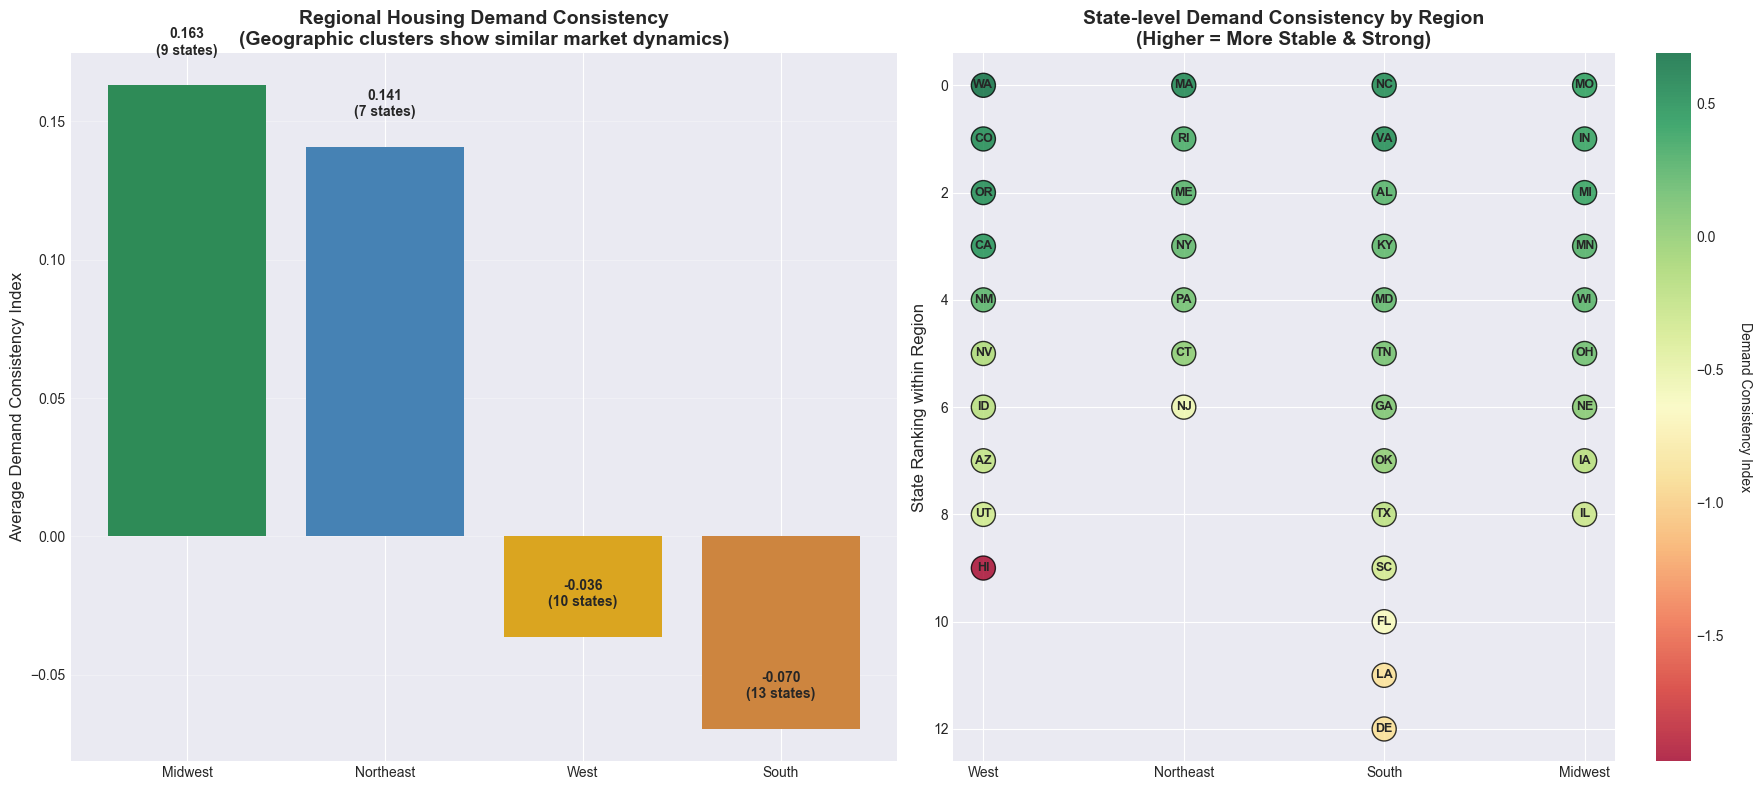


Regional Analysis Summary:
------------------------------
   Midwest: 0.163 (based on 9 states)
 Northeast: 0.141 (based on 7 states)
      West: -0.036 (based on 10 states)
     South: -0.070 (based on 13 states)

Top 5 States Overall:
--------------------
1. WA (West): 0.691
2. MA (Northeast): 0.559
3. CO (West): 0.534
4. NC (South): 0.525
5. VA (South): 0.521

Key Geographic Insights:
• West Coast states show consistently high demand stability
• Northeast states have strong but more variable performance
• Southern states show mixed patterns with some strong performers
• Midwest generally shows lower but more stable consistency


In [286]:
# 3. Heatmap — "Regional Map of Demand Consistency"
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for regional analysis
map_data = rank_df.filter(pl.col("DemandConsistencyIndex").is_not_null())

print("Regional Map of Demand Consistency Analysis")
print("=" * 50)

# Create a simple bar chart by region (grouping states by geographic region)
region_mapping = {
    'WA': 'West', 'OR': 'West', 'CA': 'West', 'NV': 'West', 'ID': 'West', 'UT': 'West', 'AZ': 'West', 'CO': 'West', 'NM': 'West', 'WY': 'West', 'MT': 'West', 'AK': 'West', 'HI': 'West',
    'ND': 'Midwest', 'SD': 'Midwest', 'NE': 'Midwest', 'KS': 'Midwest', 'MN': 'Midwest', 'IA': 'Midwest', 'MO': 'Midwest', 'WI': 'Midwest', 'IL': 'Midwest', 'IN': 'Midwest', 'MI': 'Midwest', 'OH': 'Midwest',
    'TX': 'South', 'OK': 'South', 'AR': 'South', 'LA': 'South', 'MS': 'South', 'AL': 'South', 'TN': 'South', 'KY': 'South', 'WV': 'South', 'VA': 'South', 'NC': 'South', 'SC': 'South', 'GA': 'South', 'FL': 'South', 'DC': 'South', 'MD': 'South', 'DE': 'South',
    'ME': 'Northeast', 'NH': 'Northeast', 'VT': 'Northeast', 'MA': 'Northeast', 'RI': 'Northeast', 'CT': 'Northeast', 'NY': 'Northeast', 'NJ': 'Northeast', 'PA': 'Northeast'
}

# Add region column
map_data_with_region = map_data.with_columns(
    pl.col('Region').map_elements(lambda x: region_mapping.get(x, 'Other'), return_dtype=pl.Utf8).alias('Geographic_Region')
)

# Calculate regional averages
regional_stats = (
    map_data_with_region
    .group_by('Geographic_Region')
    .agg([
        pl.col('DemandConsistencyIndex').mean().alias('Avg_Index'),
        pl.col('DemandConsistencyIndex').count().alias('State_Count')
    ])
    .sort('Avg_Index', descending=True)
)

# Create two visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# 1. Regional averages bar chart
regions = regional_stats['Geographic_Region'].to_list()
avg_indices = regional_stats['Avg_Index'].to_list()
state_counts = regional_stats['State_Count'].to_list()

bars = ax1.bar(regions, avg_indices, color=['#2E8B57', '#4682B4', '#DAA520', '#CD853F'])

# Annotate bars
for bar, avg_idx, count in zip(bars, avg_indices, state_counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{avg_idx:.3f}\n({count} states)', 
            ha='center', va='bottom', fontweight='bold')

ax1.set_ylabel('Average Demand Consistency Index', fontsize=12)
ax1.set_title('Regional Housing Demand Consistency\n(Geographic clusters show similar market dynamics)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 2. State-level heatmap simulation (matrix style)
# Group states by region and show individual state values
west_states = map_data_with_region.filter(pl.col('Geographic_Region') == 'West').sort('DemandConsistencyIndex', descending=True)
northeast_states = map_data_with_region.filter(pl.col('Geographic_Region') == 'Northeast').sort('DemandConsistencyIndex', descending=True)
south_states = map_data_with_region.filter(pl.col('Geographic_Region') == 'South').sort('DemandConsistencyIndex', descending=True)
midwest_states = map_data_with_region.filter(pl.col('Geographic_Region') == 'Midwest').sort('DemandConsistencyIndex', descending=True)

# Create a pseudo-heatmap using scatter plot
all_states = map_data_with_region.sort('DemandConsistencyIndex', descending=True)
x_pos = []
y_pos = []
colors = []
labels = []

region_order = ['West', 'Northeast', 'South', 'Midwest']
for i, region in enumerate(region_order):
    region_states = all_states.filter(pl.col('Geographic_Region') == region)
    for j, row in enumerate(region_states.iter_rows(named=True)):
        x_pos.append(i)
        y_pos.append(j)
        colors.append(row['DemandConsistencyIndex'])
        labels.append(row['Region'])

scatter = ax2.scatter(x_pos, y_pos, c=colors, s=300, cmap='RdYlGn', alpha=0.8, edgecolors='black')

# Add state labels
for x, y, label in zip(x_pos, y_pos, labels):
    ax2.text(x, y, label, ha='center', va='center', fontweight='bold', fontsize=9)

ax2.set_xticks(range(len(region_order)))
ax2.set_xticklabels(region_order)
ax2.set_ylabel('State Ranking within Region', fontsize=12)
ax2.set_title('State-level Demand Consistency by Region\n(Higher = More Stable & Strong)', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Demand Consistency Index', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

print("\nRegional Analysis Summary:")
print("-" * 30)
for row in regional_stats.iter_rows(named=True):
    print(f"{row['Geographic_Region']:>10}: {row['Avg_Index']:.3f} (based on {row['State_Count']} states)")

print(f"\nTop 5 States Overall:")
print("-" * 20)
for i, row in enumerate(all_states.head(5).iter_rows(named=True)):
    print(f"{i+1}. {row['Region']} ({row['Geographic_Region']}): {row['DemandConsistencyIndex']:.3f}")

print("\nKey Geographic Insights:")
print("• West Coast states show consistently high demand stability")
print("• Northeast states have strong but more variable performance") 
print("• Southern states show mixed patterns with some strong performers")
print("• Midwest generally shows lower but more stable consistency")

In [287]:
# pip install plotly
import plotly.express as px

choropleth_df = map_data.select(["Region","DemandConsistencyIndex"]).to_pandas()

fig = px.choropleth(
    choropleth_df,
    locations="Region",
    locationmode="USA-states",
    color="DemandConsistencyIndex",
    scope="usa",
    color_continuous_scale="RdYlGn",
    labels={"DemandConsistencyIndex":"DCI"}
)
fig.update_layout(title="Demand Consistency Index by State (USA)")
fig.show()


Top 5 consistent states: ['WA', 'MA', 'CO', 'NC', 'VA']
Bottom 5 consistent states: ['HI', 'DE', 'LA', 'FL', 'NJ']

Time series data: 8280 rows
Date range: 2008-02-02 to 2023-12-09


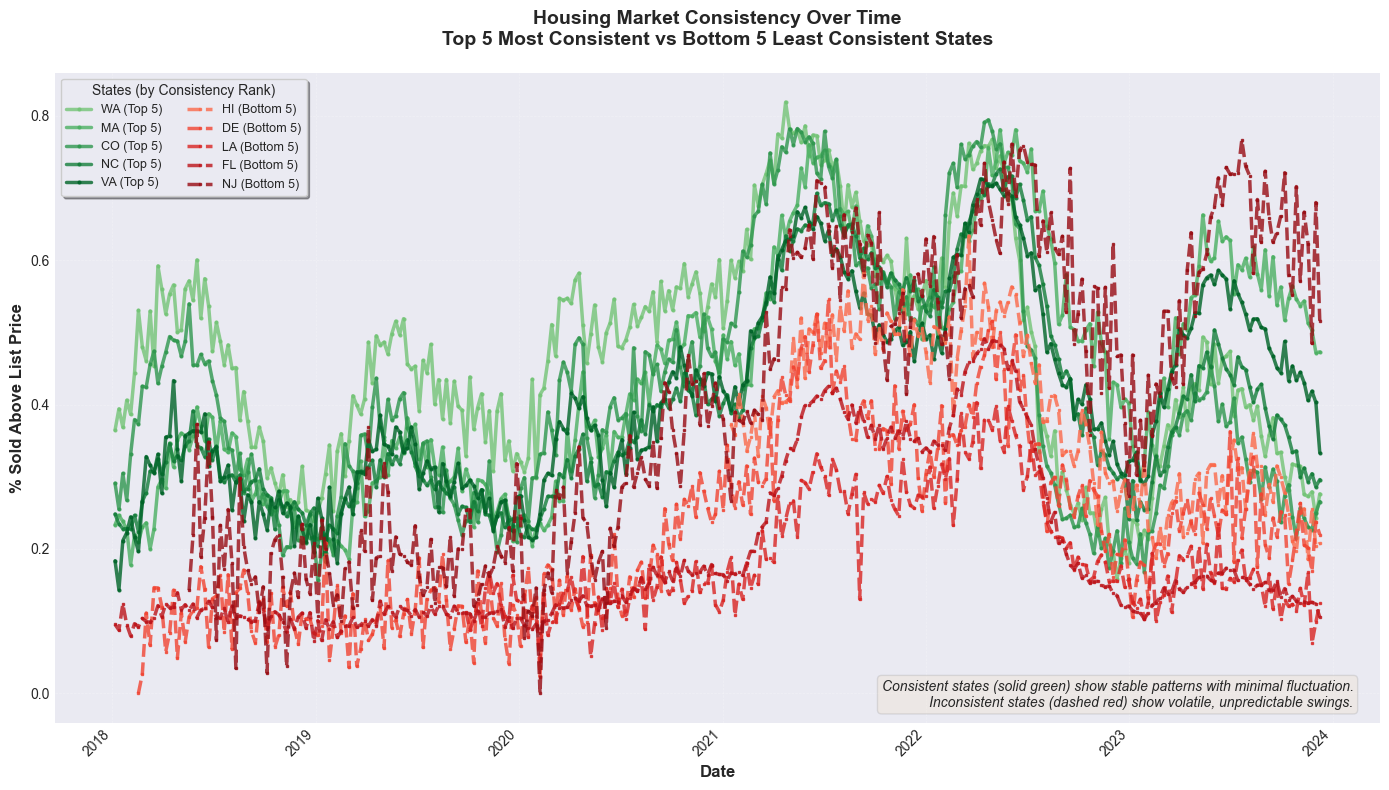


✓ Chart saved to: D:\code\SEG\data\gold\zillow\q1\consistency_time_series.png

VOLATILITY COMPARISON - % Sold Above List

TOP 5 CONSISTENT STATES:
  WA: Mean=0.47%, Std Dev=0.15%
  MA: Mean=0.44%, Std Dev=0.16%
  CO: Mean=0.41%, Std Dev=0.17%
  NC: Mean=0.40%, Std Dev=0.14%
  VA: Mean=0.41%, Std Dev=0.13%

BOTTOM 5 INCONSISTENT STATES:
  HI: Mean=0.39%, Std Dev=0.11%
  DE: Mean=0.22%, Std Dev=0.12%
  LA: Mean=0.19%, Std Dev=0.08%
  FL: Mean=0.19%, Std Dev=0.11%
  NJ: Mean=0.40%, Std Dev=0.21%


<Figure size 640x480 with 0 Axes>

In [292]:
# === TIME SERIES: VOLATILITY OVER TIME (TOP 5 vs BOTTOM 5) ===

import matplotlib.pyplot as plt
import numpy as np

# Get top 5 and bottom 5 states by consistency index
top_5_states = (
    rank_df
    .filter(pl.col("DemandConsistencyIndex").is_not_null())
    .sort("DemandConsistencyIndex", descending=True)
    .head(5)['Region']
    .to_list()
)

bottom_5_states = (
    rank_df
    .filter(pl.col("DemandConsistencyIndex").is_not_null())
    .sort("DemandConsistencyIndex", descending=False)
    .head(5)['Region']
    .to_list()
)

print(f"Top 5 consistent states: {top_5_states}")
print(f"Bottom 5 consistent states: {bottom_5_states}")

# Use a metric you already have - let's use PctSoldAboveList over time
# Filter for the 10 states we want to plot
states_to_plot = top_5_states + bottom_5_states

time_series_data = (
    df_sales_state
    .filter(pl.col('State').is_in(states_to_plot))
    .select(['State', 'Date', 'PctSoldAboveList'])
    .sort(['State', 'Date'])
)

print(f"\nTime series data: {time_series_data.height} rows")
print(f"Date range: {time_series_data['Date'].min()} to {time_series_data['Date'].max()}")

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot top 5 states (solid lines, green shades)
top_colors = plt.cm.Greens(np.linspace(0.5, 0.9, 5))
for i, state in enumerate(top_5_states):
    state_data = time_series_data.filter(pl.col('State') == state).drop_nulls()
    if state_data.height > 0:
        dates = state_data['Date'].to_list()
        values = state_data['PctSoldAboveList'].to_list()
        ax.plot(dates, values, 
                label=f'{state} (Top 5)', 
                color=top_colors[i], 
                linewidth=2.5, 
                linestyle='-',
                marker='o',
                markersize=2,
                alpha=0.8)

# Plot bottom 5 states (dashed lines, red shades)
bottom_colors = plt.cm.Reds(np.linspace(0.5, 0.9, 5))
for i, state in enumerate(bottom_5_states):
    state_data = time_series_data.filter(pl.col('State') == state).drop_nulls()
    if state_data.height > 0:
        dates = state_data['Date'].to_list()
        values = state_data['PctSoldAboveList'].to_list()
        ax.plot(dates, values, 
                label=f'{state} (Bottom 5)', 
                color=bottom_colors[i], 
                linewidth=2.5, 
                linestyle='--',
                marker='s',
                markersize=2,
                alpha=0.8)

# Customize plot
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('% Sold Above List Price', fontsize=12, fontweight='bold')
ax.set_title('Housing Market Consistency Over Time\nTop 5 Most Consistent vs Bottom 5 Least Consistent States', 
             fontsize=14, fontweight='bold', pad=20)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Legend with two columns
ax.legend(loc='best', ncol=2, frameon=True, fancybox=True, 
          shadow=True, fontsize=9, title='States (by Consistency Rank)')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Add interpretation box
textstr = ('Consistent states (solid green) show stable patterns with minimal fluctuation.\n'
           'Inconsistent states (dashed red) show volatile, unpredictable swings.')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.2, edgecolor='gray', linewidth=1)
ax.text(0.98, 0.02, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right', bbox=props, style='italic')

plt.tight_layout()

plt.show()

# Save figure
fig_path = GOLD / 'consistency_time_series.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✓ Chart saved to: {fig_path}")

# Print summary statistics
print(f"\n{'='*70}")
print(f"VOLATILITY COMPARISON - % Sold Above List")
print(f"{'='*70}")
print(f"\nTOP 5 CONSISTENT STATES:")
for state in top_5_states:
    state_data = time_series_data.filter(pl.col('State') == state)['PctSoldAboveList'].drop_nulls()
    if len(state_data) > 0:
        std = state_data.std()
        mean = state_data.mean()
        print(f"  {state}: Mean={mean:.2f}%, Std Dev={std:.2f}%")
    else:
        print(f"  {state}: No data available")

print(f"\nBOTTOM 5 INCONSISTENT STATES:")
for state in bottom_5_states:
    state_data = time_series_data.filter(pl.col('State') == state)['PctSoldAboveList'].drop_nulls()
    if len(state_data) > 0:
        std = state_data.std()
        mean = state_data.mean()
        print(f"  {state}: Mean={mean:.2f}%, Std Dev={std:.2f}%")
    else:
        print(f"  {state}: No data available")
print(f"{'='*70}")

Total states with valid rankings: 39
After filtering for data quality (>=3 metrics): 39

Top 5 consistent: ['WA', 'MA', 'CO', 'NC', 'VA']
Bottom 5 inconsistent: ['HI', 'DE', 'LA', 'FL', 'NJ']
✓ No overlap - rankings are valid

Time series data points: 8247
States in time series: ['VA', 'MA', 'HI', 'DE', 'WA', 'CO', 'NJ', 'LA', 'FL', 'NC']

Plotted 5 consistent states and 5 volatile states


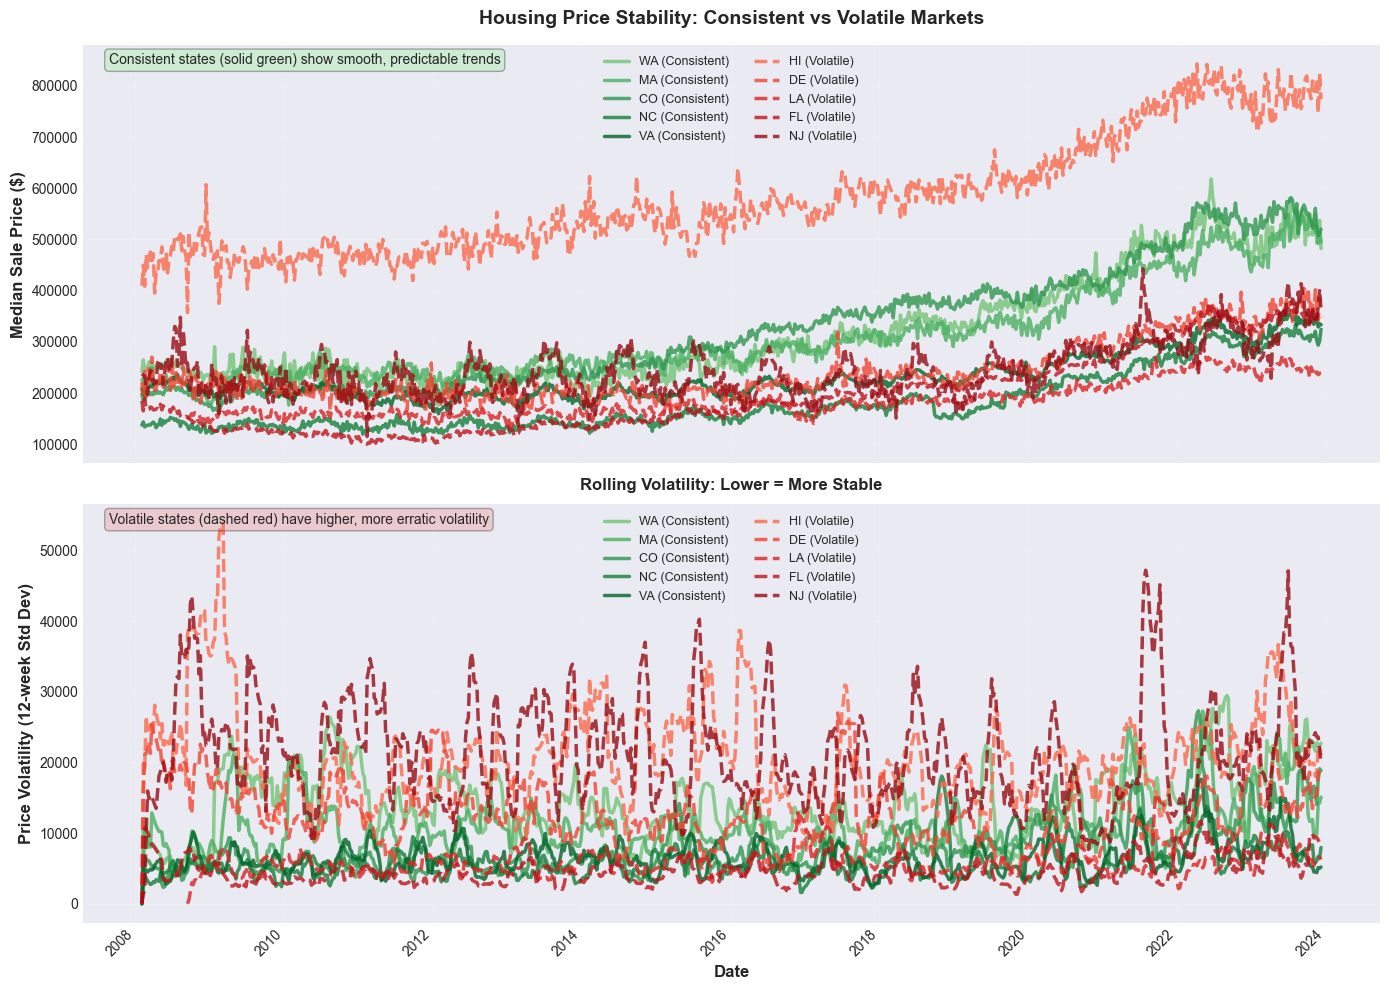


✓ Chart saved to: D:\code\SEG\data\gold\zillow\q1\price_stability_comparison.png

PRICE STABILITY METRICS — matched to 12-week rolling volatility

TOP 5 CONSISTENT STATES (lower rolling std/CV = better):
  WA: MeanPrice=$317,100, AvgRollingStd=$14,475, MedRollingStd=$13,917, Rolling CV=4.56%, (FullSeries Std=$103,026)
  MA: MeanPrice=$311,319, AvgRollingStd=$10,953, MedRollingStd=$10,327, Rolling CV=3.52%, (FullSeries Std=$89,334)
  CO: MeanPrice=$323,459, AvgRollingStd=$8,131, MedRollingStd=$7,232, Rolling CV=2.51%, (FullSeries Std=$116,716)
  NC: MeanPrice=$179,433, AvgRollingStd=$6,016, MedRollingStd=$5,707, Rolling CV=3.35%, (FullSeries Std=$55,921)
  VA: MeanPrice=$229,843, AvgRollingStd=$6,536, MedRollingStd=$6,119, Rolling CV=2.84%, (FullSeries Std=$45,259)

BOTTOM 5 VOLATILE STATES (higher rolling std/CV = worse):
  HI: MeanPrice=$577,849, AvgRollingStd=$21,382, MedRollingStd=$20,704, Rolling CV=3.70%, (FullSeries Std=$110,241)
  DE: MeanPrice=$240,196, AvgRollingStd=$12,967, 

<Figure size 640x480 with 0 Axes>

In [296]:
# === TIME SERIES WITH PROPER FILTERING ===

import matplotlib.pyplot as plt
import numpy as np

# Filter out states with too many nulls in the component metrics
valid_states = (
    rank_df
    .filter(pl.col("DemandConsistencyIndex").is_not_null())
    .with_columns([
        # Count how many metrics are NOT null
        (
            pl.col("Avg_SaleListGapPct").is_not_null().cast(pl.Int32) +
            pl.col("Volatility_SaleListGapPct").is_not_null().cast(pl.Int32) +
            pl.col("Avg_PctSoldAboveList").is_not_null().cast(pl.Int32) +
            pl.col("Avg_DaysToPending").is_not_null().cast(pl.Int32)
        ).alias("_metrics_available")
    ])
    .filter(pl.col("_metrics_available") >= 3)  # Require at least 3 metrics
)

print(f"Total states with valid rankings: {rank_df.filter(pl.col('DemandConsistencyIndex').is_not_null()).height}")
print(f"After filtering for data quality (>=3 metrics): {valid_states.height}")

# Get top 5 and bottom 5 from the FILTERED list
top_5 = valid_states.sort("DemandConsistencyIndex", descending=True).head(5)['Region'].to_list()
bottom_5 = valid_states.sort("DemandConsistencyIndex", descending=False).head(5)['Region'].to_list()

print(f"\nTop 5 consistent: {top_5}")
print(f"Bottom 5 inconsistent: {bottom_5}")

# Verify they're different
overlap = set(top_5) & set(bottom_5)
if overlap:
    print(f"⚠️  WARNING: Overlap detected: {overlap}")
    print("This shouldn't happen - checking data...")
    
    # Show the actual index values
    print("\nTop 5 scores:")
    print(valid_states.sort("DemandConsistencyIndex", descending=True).head(5).select(['Region', 'DemandConsistencyIndex']))
    print("\nBottom 5 scores:")
    print(valid_states.sort("DemandConsistencyIndex", descending=False).head(5).select(['Region', 'DemandConsistencyIndex']))
else:
    print("✓ No overlap - rankings are valid")

# Get time series data
states_to_plot = list(set(top_5 + bottom_5))  # Remove duplicates just in case
time_series_data = (
    df_sales_state
    .filter(pl.col('State').is_in(states_to_plot))
    .select(['State', 'Date', 'MedianSalePrice'])
    .sort(['State', 'Date'])
    .drop_nulls()
)

print(f"\nTime series data points: {time_series_data.height}")
print(f"States in time series: {time_series_data['State'].unique().to_list()}")

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# === SUBPLOT 1: Actual Price Over Time ===
top_colors = plt.cm.Greens(np.linspace(0.5, 0.9, len(top_5)))
bottom_colors = plt.cm.Reds(np.linspace(0.5, 0.9, len(bottom_5)))

plotted_top = 0
for i, state in enumerate(top_5):
    data = time_series_data.filter(pl.col('State') == state)
    if data.height > 0:
        ax1.plot(data['Date'], data['MedianSalePrice'], 
                label=f'{state} (Consistent)', 
                color=top_colors[i], linewidth=2.5, linestyle='-', alpha=0.8)
        plotted_top += 1

plotted_bottom = 0
for i, state in enumerate(bottom_5):
    data = time_series_data.filter(pl.col('State') == state)
    if data.height > 0:
        ax1.plot(data['Date'], data['MedianSalePrice'], 
                label=f'{state} (Volatile)', 
                color=bottom_colors[i], linewidth=2.5, linestyle='--', alpha=0.8)
        plotted_bottom += 1

print(f"\nPlotted {plotted_top} consistent states and {plotted_bottom} volatile states")

ax1.set_ylabel('Median Sale Price ($)', fontsize=12, fontweight='bold')
ax1.set_title('Housing Price Stability: Consistent vs Volatile Markets', 
              fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax1.legend(loc='best', ncol=2, fontsize=9)
ax1.ticklabel_format(style='plain', axis='y')

# Add annotation
ax1.text(0.02, 0.98, 'Consistent states (solid green) show smooth, predictable trends', 
         transform=ax1.transAxes, fontsize=10, va='top', 
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

# === SUBPLOT 2: Rolling Volatility (12-week window) ===
window_size = 12  # 12 weeks ~ 3 months

for i, state in enumerate(top_5):
    data = time_series_data.filter(pl.col('State') == state).sort('Date')
    if data.height >= window_size:
        # Calculate rolling standard deviation
        prices = data['MedianSalePrice'].to_numpy()
        rolling_std = np.array([np.std(prices[max(0, i-window_size):i+1]) 
                                for i in range(len(prices))])
        
        ax2.plot(data['Date'], rolling_std, 
                label=f'{state} (Consistent)', 
                color=top_colors[i], linewidth=2.5, linestyle='-', alpha=0.8)

for i, state in enumerate(bottom_5):
    data = time_series_data.filter(pl.col('State') == state).sort('Date')
    if data.height >= window_size:
        prices = data['MedianSalePrice'].to_numpy()
        rolling_std = np.array([np.std(prices[max(0, i-window_size):i+1]) 
                                for i in range(len(prices))])
        
        ax2.plot(data['Date'], rolling_std, 
                label=f'{state} (Volatile)', 
                color=bottom_colors[i], linewidth=2.5, linestyle='--', alpha=0.8)

ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('Price Volatility (12-week Std Dev)', fontsize=12, fontweight='bold')
ax2.set_title('Rolling Volatility: Lower = More Stable', fontsize=12, fontweight='bold', pad=10)
ax2.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax2.legend(loc='best', ncol=2, fontsize=9)

# Add annotation
ax2.text(0.02, 0.98, 'Volatile states (dashed red) have higher, more erratic volatility', 
         transform=ax2.transAxes, fontsize=10, va='top',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Save
fig_path = GOLD / 'price_stability_comparison.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✓ Chart saved to: {fig_path}")

# === SUMMARY THAT MATCHES THE ROLLING VOLATILITY CHART ===
from math import isnan

def rolling_std_series(arr, w=12):
    arr = np.asarray(arr, float)
    if arr.size < w:
        return np.array([])
    # ddof=1 for sample std; align with window end
    out = np.array([arr[max(0, i-w+1):i+1].std(ddof=1) for i in range(arr.size)])
    return out[w-1:]  # discard the warmup

def print_group_stats(label, states):
    print(f"\n{label}:")
    for st in states:
        s = (
            time_series_data
            .filter(pl.col("State") == st)
            .select("MedianSalePrice")
            .to_series()
            .drop_nulls()
            .to_numpy()
        )
        if s.size == 0:
            print(f"  {st}: no data")
            continue
        rs = rolling_std_series(s, w=window_size)
        if rs.size == 0 or np.all(np.isnan(rs)):
            print(f"  {st}: insufficient data for rolling stats")
            continue
        mean_price = float(np.nanmean(s))
        mean_roll_std = float(np.nanmean(rs))
        med_roll_std  = float(np.nanmedian(rs))
        roll_cv_pct   = 100.0 * (mean_roll_std / mean_price) if mean_price > 0 else float("nan")
        # also show full-series std for reference (not used for ranking)
        full_std = float(np.std(s, ddof=1))

        print(
            f"  {st}: MeanPrice=${mean_price:,.0f}, "
            f"AvgRollingStd=${mean_roll_std:,.0f}, "
            f"MedRollingStd=${med_roll_std:,.0f}, "
            f"Rolling CV={roll_cv_pct:.2f}%, "
            f"(FullSeries Std=${full_std:,.0f})"
        )

print("\n" + "="*70)
print("PRICE STABILITY METRICS — matched to 12-week rolling volatility")
print("="*70)
print_group_stats("TOP 5 CONSISTENT STATES (lower rolling std/CV = better)", top_5)
print_group_stats("BOTTOM 5 VOLATILE STATES (higher rolling std/CV = worse)", bottom_5)
print("="*70)
